# 3.2 Classification/Regression

Python program to build and test a model for gwp and star dataset, using the dataset obtained from Task 3.1.

In [263]:
import numpy as np
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from pandas import DataFrame

%load_ext autoreload
%autoreload 2

import bamboo.gwp_pipeline as gwp
import bamboo.star_pipeline as star
from bamboo.processing import read_csv, split_features_and_target, get_feature_and_target_names 
from bamboo.selection import normalize_train_test, filter_features
from bamboo.model import ModelManager, get_classification_prediction_data
from bamboo.analysis import *

SEED = 42

GWP_CSV = 'datasets/gwp_assessment.csv'
STAR_CSV = 'datasets/star_assessment.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Preperation

Load GWP dataset.

In [264]:
# Load data from csv and process it
gwp_data = read_csv(GWP_CSV)
gwp_dataset = gwp.gwp_pipeline(gwp_data, seed=SEED)

# Split feature and target sets
X_gwp, y_gwp = split_features_and_target(gwp_dataset)
X_gwp_names, y_gwp_name = get_feature_and_target_names(gwp_dataset)

# Apply feature selection
X_gwp, X_gwp_names = filter_features(X_gwp, y_gwp, X_gwp_names, corr_coef=0.05, const_coef=0.01)

# Split the data into training and test sets and normalise the data
X_gwp_train, X_gwp_test, y_gwp_train, y_gwp_test = train_test_split(X_gwp, y_gwp, test_size=0.2, random_state=SEED)
X_gwp_train, X_gwp_test = normalize_train_test(X_gwp_train, X_gwp_test)

/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Load Star dataset.

In [265]:
# Load data from csv and process it
star_data = read_csv(STAR_CSV)
star_dataset = star.star_pipeline(star_data, seed=SEED)

# Split feature and target sets
X_star, y_star = split_features_and_target(star_dataset)
X_star_names, y_star_name = get_feature_and_target_names(star_dataset)

# Apply feature selection
X_star, X_star_names = filter_features(X_star, y_star, X_star_names, corr_coef=0.01, const_coef=0.01)

# Split the data into training and test sets and normalise the data
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.2, random_state=SEED)
X_star_train, X_star_test = normalize_train_test(X_star_train, X_star_test)

## GWP Model implementation & training
Support Vector Regression (SVR) model.

In [ ]:
# Initialize the SVR model parammeters
parameters = {
    'kernel': ['rbf', 'linear', 'poly','rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

svr = SVR()

# Instantiate the Model class with SVR model and the parameter grid
gwp_model = ModelManager(model=svr, params=parameters, search_type='GridSearch')
gwp_model.fit(X_gwp_train, y_gwp_train)

# Save the model
gwp_model.save_model('models/gwp/svr.pkl')
gwp_model.save_results('results/gwp/svr.pkl')

## Star Model implementation & training
Support Vector Classification (SVC) model.

<div class="warning">
    <strong>Warning:</strong> Running this model with all parameter configurations may take upwards of an hour to complete. You can load in the saved model and result from the local directories if you would like to use the model instead.
</div>

<style>
.warning {
    background-color: #ffeeba;
    border-color: #ffc107;
    color: #856404;
    padding: 1em;
    margin-top: 1em;
    margin-bottom: 1em;
    border: 1px solid transparent;
    border-radius: 0.25rem;
}
</style>

In [ ]:
# Initialize the SVC search parammeters
parameters = {
    'kernel': ['rbf', 'linear', 'poly','rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
}

svc = SVC(probability=True, random_state=SEED)

# Instantiate the Model class with SVR model and the parameter grid
star_model = ModelManager(model=svc, params=parameters, search_type="HalvingGridSearch")
star_model.fit(X_star_train, y_star_train)

# Save the model
star_model.save_model('models/star/svc.pkl')
star_model.save_results('results/star/svc.pkl')

## GWP Model Analysis

Load in the saved gwp model and results.

In [268]:
gwp_model = ModelManager()
gwp_model.load_model('models/gwp/svr.pkl')
gwp_model.load_results('results/gwp/svr.pkl')

Show best model results from parameter tuning

In [273]:
gwp_model.get_best_configuration()

{'Best Params': {'C': 10, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'},
 'Best Score': 0.27,
 'Time Taken': 0.029}

### Average time & score for each parameter tested
Data collected on 320 parameter configurations using GridSearchCV to find optimal parameter configuration. Each parameter value's average was taken across the 320 configurations and plotted below.

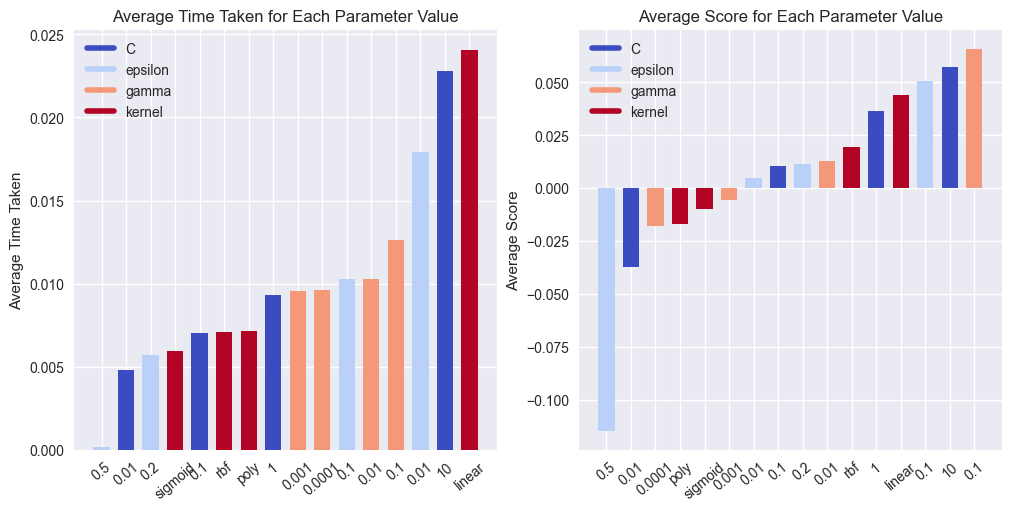

In [270]:
gwp_configurations = gwp_model.get_configurations(sort_by='Score', n_results=250, ascending=False)
plot_bar_avg_metrics(gwp_configurations)

### Predicting on Test set

In [220]:
y_gwp_pred = gwp_model.predict(X_gwp_test)
print_regression_metrics(y_gwp_test, y_gwp_pred)

Score (R-squared): 0.42315311578169146
Mean Absolute Error (MAE): 0.08275253986694049
Root Mean Squared Error (RMSE): 0.123760686740424


#### Scatter Plot: Predicted vs Actual
Compares model predictions to actual test set values. Deviation from the dotted line (where predictions perfectly match actual values) signifies model inaccuracies, with close grouping around the line indicating good model fit.

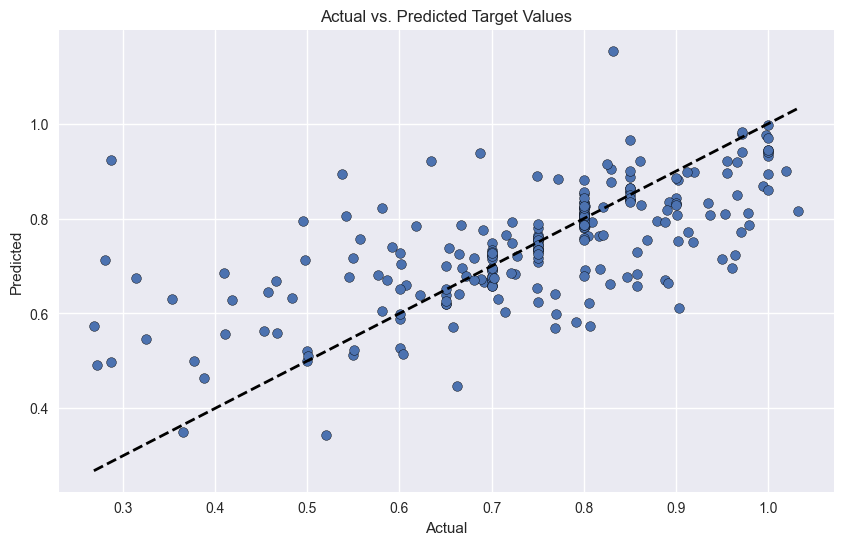

In [271]:
plot_predicted_vs_actual(y_gwp_test, y_gwp_pred)

## Star Model Analysis

Load in the saved star model and results.

In [206]:
star_model = ModelManager()
star_model.load_model('models/star/svc.pkl')
star_model.load_results('results/star/svc.pkl')

Show best model results from parameter tuning

In [275]:
star_model.get_best_configuration()

119

### Precision Recall, ROC, DET Curves

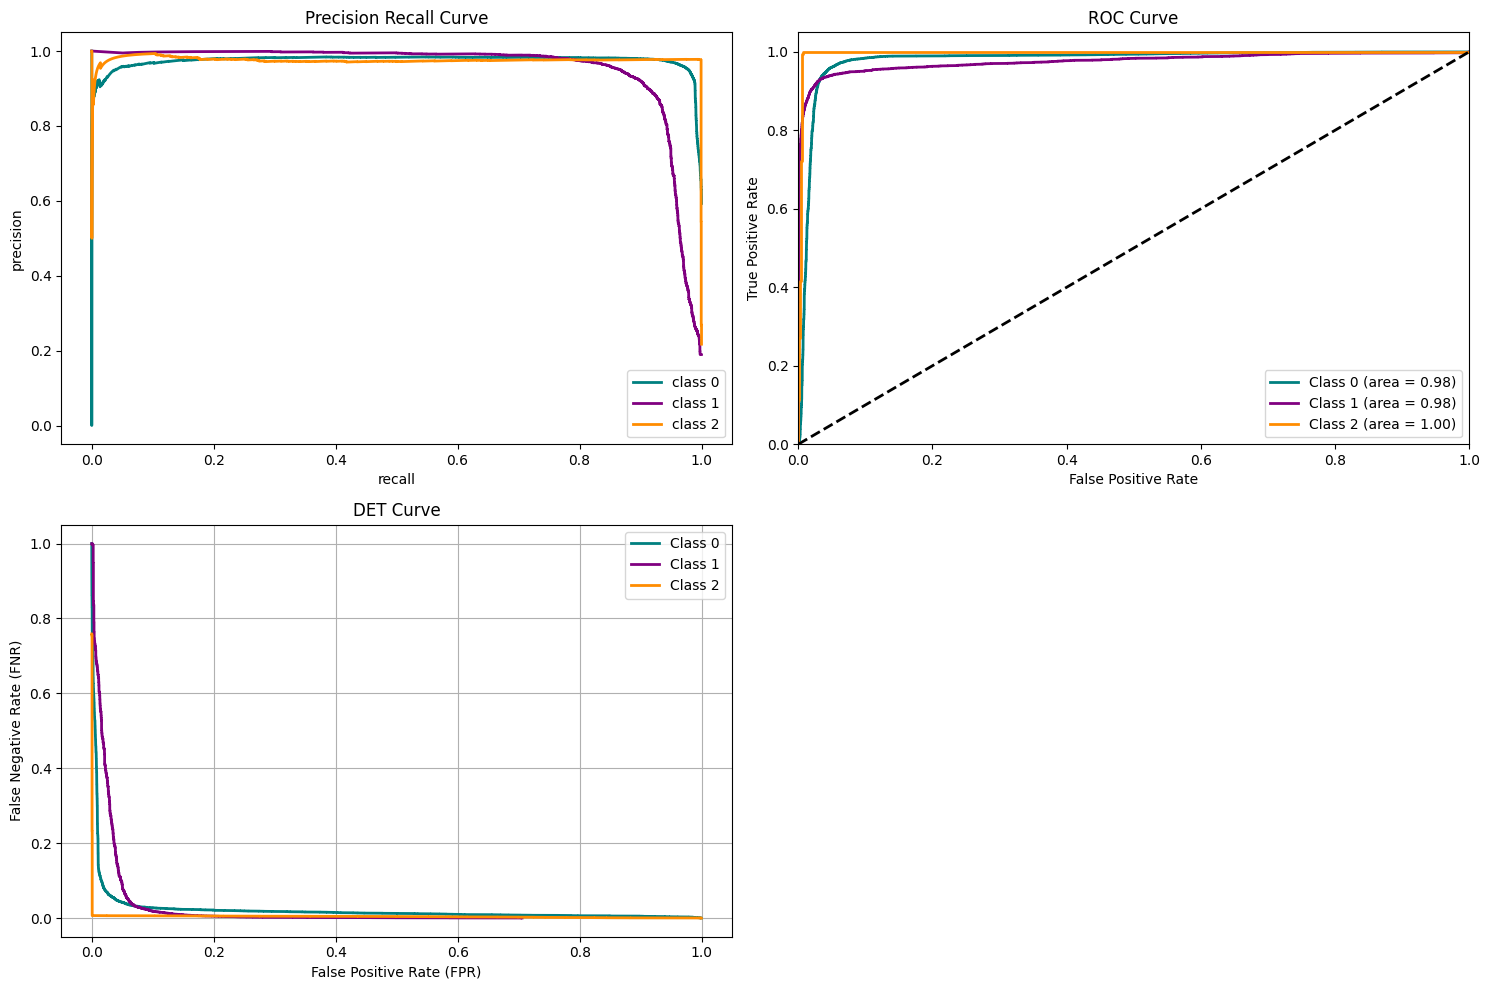

In [101]:
classes = np.unique(y_star_test)
data_per_class = get_classification_prediction_data(star_model.model, X_star_test, y_star_test, classes)

plot_side_by_side(
    lambda: plot_precision_recall_curve(data_per_class, classes), 
    lambda: plot_roc_curve(data_per_class, classes),
    lambda: plot_det_curve(data_per_class, classes),
    titles=['Precision Recall Curve', 'ROC Curve', 'DET Curve'],
    num_cols=2,
    figsize=(15, 10))


### Average time & score for each parameter tested
Data collected on 119 parameter configurations using HalvingGridSearchCV to find optimal parameter configuration.

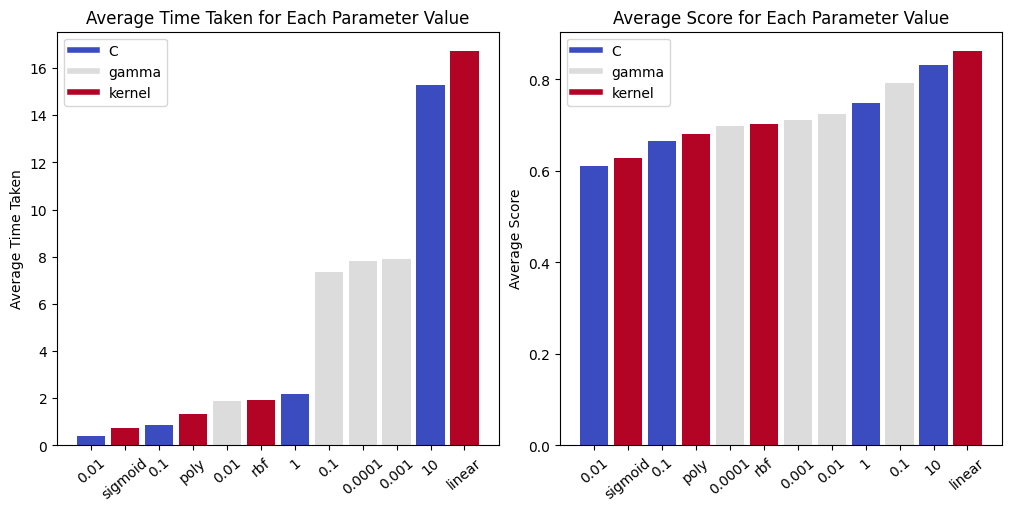

In [199]:
star_configurations = star_model.get_configurations(sort_by='Score', n_results=None, ascending=False)
plot_bar_avg_metrics(star_configurations)

### Predicting on Test set

In [221]:
y_star_pred = star_model.predict(X_star_test)
print("Prediction Score: ", star_model.model.score(X_star_test, y_star_test))

Prediction Score:  0.9552


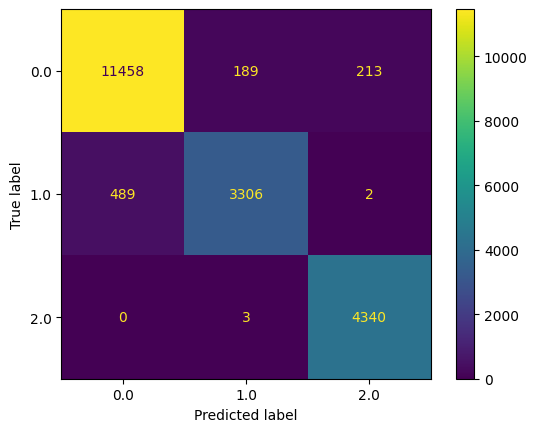

In [210]:
ConfusionMatrixDisplay.from_predictions(y_star_test, y_star_pred)
plt.show()

#### Markdown Question: 
**Question**: Is Linear Regression a good model to use for the star dataset? Justify your answer.